# Main Game Logic v4
- Modified: 19 Apr 2025
    - Uses gpt-4.1-mini
    - Added Coordinate, Action and Prediction Chain of Thought for previous state to check for successful action with current state

- Modified: 13 Mar 2025
    - Uses `parse_yaml` from strictjson (functionality to be added to AgentJo shortly after more testing!)
    - Added Prediction, Insights, better Context
    - Added Thoughts streaming

In [24]:
from dotenv import load_dotenv
import time
from IPython.display import clear_output

# put your secret keys in your .env
# For instance, if you are using OpenAI, your .env should contain
# export OPENAI_API_KEY = "sk-......."
load_dotenv()

True

In [25]:
# !pip install openai

In [26]:
# !pip install agentjo

# Interface with AgentJo

In [27]:
from strictjson import parse_yaml

In [28]:
import os
import re
import base64
import mimetypes

def replace_image_marker(func):
    """
    A decorator that scans the user prompt for markers in the form <<marker>>.
    For each marker:
      - If it is a URL (i.e. starts with "http://" or "https://"), it is replaced
        with an image dictionary in the OpenAI expected format.
      - If the marker corresponds to a local image file (exists in the current directory),
        it is read, encoded in Base64, and converted into a data URL.
      - All non-marker text is wrapped as a text part.
    The resulting list (mixing text and image dictionaries) is passed to the wrapped function.
    """
    def wrapper(system_prompt: str, user_prompt: str):
        if '<<' in user_prompt and '>>' in user_prompt:
            # Split by markers; odd-indexed parts are markers.
            parts = re.split(r'<<(.*?)>>', user_prompt)
            new_contents = []
            for idx, part in enumerate(parts):
                if idx % 2 == 1:
                    marker = part.strip()
                    if marker.startswith("http://") or marker.startswith("https://"):
                        new_contents.append({"type": "image_url", "image_url": {"url": marker}})
                    elif os.path.isfile(marker):
                        # Get MIME type based on file extension
                        mime_type, _ = mimetypes.guess_type(marker)
                        if mime_type is None:
                            mime_type = "application/octet-stream"
                        # Encode the image in Base64
                        with open(marker, "rb") as f:
                            encoded = base64.b64encode(f.read()).decode("utf-8")
                        data_url = f"data:{mime_type};base64,{encoded}"
                        new_contents.append({"type": "image_url", "image_url": {"url": data_url}})
                    else:
                        # If marker is not a URL or valid file, treat it as literal text.
                        new_contents.append({"type": "text", "text": f"<<{marker}>>"})
                else:
                    if part:
                        new_contents.append({"type": "text", "text": part})
            return func(system_prompt, new_contents)
        else:
            # If no markers, wrap the entire prompt as text.
            return func(system_prompt, [{"type": "text", "text": user_prompt}])
    return wrapper

@replace_image_marker
def openai(system_prompt: str, user_prompt):
    """
    Calls the OpenAI API.

    The processed `user_prompt` (a list of dictionaries mixing text and image_url types)
    is passed as the content of the user message. Optionally, a system message is also included.
    """
    from openai import OpenAI

    client = OpenAI()

    messages = []
    if system_prompt:
        messages.append({
            "role": "system",
            "content": [{"type": "text", "text": system_prompt}]
        })
    messages.append({
        "role": "user",
        "content": user_prompt
    })

    response = client.chat.completions.create(
        model="gpt-4.1-mini",
        messages=messages
    )
    return response.choices[0].message.content

In [29]:
import requests
import base64
from PIL import Image
from io import BytesIO
from IPython.display import display
import os

BASE_URL = os.environ['BASE_URL']

# Initialize the game
# requests.post(f"{BASE_URL}/init", json={"rom_path": "PokemonRed.gb"})

count = 0

conversation = []
context_schema = {"Long-term Goals": "State your overall goals to win the game, be detailed and specific, list",
"Short-term Goal": "State what you are trying to do now, be detailed and specific. Describe in detail how the game will be when the goal is completed",
"Target Object or Menu Option to Navigate to": "State the target object in grid world or target menu option you are trying to navigate to, NA if nothing",
"Important Information": "Important knowledge about the world that can help with goals",
"Inventory": "Important items in inventory to help with goals",
"Grid Coordinates Visited": "Update with Current Coordinates, list",
"Map Transition Coordinates": "Updated with (map_id, x, y) -> (map_id, x, y) whenever a map_id is changed, list",
"List of NPCs Interacted": "NPCs who you have interacted with in the form of Person_Name (map_id, x, y) - Summary of Dialogue, list",
"List of Insights Gained": "If action is unsuccessful, write down how to make it successful. Be specific and write down full context, list"}
context = ''

# delete past images
from pathlib import Path
folder = Path("Images")
for file in folder.glob("*"):
    if file.is_file():  # Check if it's a file
        file.unlink()

# Helper Function to overlay the coordinates

{'Current View': '2D Grid',
 'Description for State 12': 'The player is in a room facing up. There is a '
                             'table with flowers to the bottom left and a '
                             'person sitting at the table. There is a blue '
                             'object to the left. There are windows to the '
                             'top.',
 'Coordinates for State 11': '(38, 7, 2)',
 'Action for State 11': 'a',
 'Prediction for State 12': 'The player will go up the staircase and the '
                            'map_id will change.',
 'Coordinates for State 12': '(37, 7, 1)',
 'Is Action Successful': False,
 'Reflection': 'The previous action was not successful. I will try moving up '
               'to go up the staircase.',
 'Thoughts': 'The previous actions were not successful. I will try moving up '
             'to go up the staircase.',
 'Action for State 12': 'up',
 'Prediction for State 13': 'The player will go up the staircase and the '
         

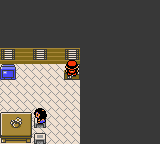

{'badges': {'badges': [], 'badges_byte': 0, 'count': 0}, 'events': {}, 'last_button': 'a', 'party': {'party_size': 0, 'pokemon': []}, 'position': {'map_id': 37, 'x': 7, 'y': 1}}
7
1


KeyboardInterrupt: 

In [31]:
import pprint
while True:
    # Get the current screen
    response = requests.get(f"{BASE_URL}/screen?format=base64")
    screen_data = response.json()["image"]
    screen_image = Image.open(BytesIO(base64.b64decode(screen_data)))
    
    # Save the image in the specified directory with a filename that includes the current count
    screen_image.save(f"Images/image_{count}.png")
    
    # Get game state
    game_state = requests.get(f"{BASE_URL}/state").json()
    
    # Make a decision based on the state and screen
    # ... AI logic here ...
    res = parse_yaml('''Based on the image and game state, make a decision of what to do next.
If previous action did not match up to prediction, try other actions.

Coordinates are given as (map_id, x, y), map_id being the id of the current map, x being the left to right axis, y being the up to down axis
Every map as a unique map_id, if map_id changes, it is treated as changing location. You should explore the new location if it is unexplored.
left in the negative x direction, e.g. (map_id, x, y) to (map_id, x-1, y)
right in the positive x direction, e.g. (map_id, x, y) to (map_id, x+1, y),
up in the negative y direction, e.g. (map_id, x, y) to (map_id, x, y-1)
down in the positive y direction, e.g. (map_id, x, y) to (map_id, x, y+1)
a is typically used for confirming actions, selecting options, and interacting with elements in the game. You can only interact with elements right next to you.
b is typically used to cancel actions, go back to the previous screen, or exit menus
start is used to open the main menu, allowing players to access options like the Pokémon menu, bag, items, and settings
select is used to register key items, allowing players to quickly access them during gameplay

You can only enter or exit places via doors, ladders, cave holes, staircases.
If inside a house, you can exit via a rectangular floor rug and moving out of the house.
Black map boundaries are not traversable.
You are in red.

Be detailed in your explanations.
State whether the previous action is successful by seeing whether the predicted state is reflected in the Current State.
Generate Insights if any, to repeat successful actions or to prevent making bad actions.
Update the Current Context as Updated Context''',
    f'''```
Current State: {count}
Current Game Image: <<Images/image_{count}.png>>
Current RAM State: {game_state}
Current Context: {context}
```
Last 20 Past States: {conversation[-20:]}''',
    output_format = {"Current View": "Enum['World Map', 'Dialogue', 'Menu', '2D Grid', 'Other']",
f"Description for State {count}": f'''Describe Current Game Image in detail for someone without the image to understand. 
Do not use details from previous Game Images.
Only state what is there and do not hallucinate. Highlight the important information relevant to the Goal or Target Object. 
If dialogue or menu or battle, highlight the options and status and where the cursor is pointing to.
If 2D grid view, state relative positions of all objects or NPCs with respect to the red player (you) using relative directions of top, bottom, left, right''',
                     f"Coordinates for State {count-1}": "Write exactly previous (map_id, x, y)",
                     f"Action for State {count-1}": "Write exactly previous action, if any",
                     f"Prediction for State {count}": "Write exactly previous prediction, if any",
                     f"Coordinates for State {count}": "State the (map_id, x, y) of Current RAM State",
                     "Is Action Successful": f"Whether the previous prediction matches current state, bool",
                     "Reflection": "Reflect on why the action is successful or not successful. If action is not successful, suggest another action",
                     "Thoughts": "Describe whether past actions are successful and how you plan to achieve your goal",
                     f"Action for State {count}": "Choose an action in line with Thoughts, Enum['up', 'down', 'left', 'right', 'a', 'b', 'start', 'select']",
                     f"Prediction for State {count+1}": "What will happen after the action is done. If it is a movement, state coordinates or menu option that we will expect to be in",
                     "Updated Context": context_schema},
                      llm = llm)

    # Update the context
    context = res["Updated Context"]
    
    next_move = res[f"Action for State {count}"]
    
    # Add in what happened in previous state in conversation history
    pprint.pprint(res, sort_dicts = False)

    # Show the thoughts
    thoughts = {'Current State': res[f'Description for State {count}'], 'Thoughts': res['Thoughts'], 'Action': res[f'Action for State {count}'], f'Prediction for State {count+1}': res[f'Prediction for State {count+1}']}
    requests.post(f"{BASE_URL}/agent/thoughts", json={"thought": json.dumps(thoughts, indent=4)})

    # Show the memory
    requests.post(f"{BASE_URL}/agent/memory", json={"memory": json.dumps(context, indent=4)})

    thoughts_internal = {f'Description for State {count}': res[f'Description for State {count}'], f'Thoughts for State {count}': res['Thoughts'], f'Action for State {count}': res[f'Action for State {count}'], f'Prediction for State {count+1}': res[f'Prediction for State {count+1}']}
    thoughts_internal[f"Game Image for State {count}"] = f"<<Images/image_{count}.png>>"
    conversation.append(json.dumps(thoughts_internal, indent=4))
                      
    # Increment count by 1 for the next image
    count += 1
    
    # Execute an action
    requests.post(f"{BASE_URL}/button", json={"button": next_move, "delay": 4})
    
    display(screen_image)
    print(game_state)
    print(game_state['position']['x'])
    print(game_state['position']['y'])
    
    time.sleep(5)
    clear_output(wait=True)